In [16]:
import pandas as pd
import numpy as np

In [17]:
data = pd.read_csv("./clean_data_clst.csv")

# features = ['total_throughput', 'latitude', 'longitude', 'square_id', 'average_latency']
features = ['latitude', 'longitude', 'average_latency', 'total_throughput', 'speed']
# features = ['average_latency', 'total_throughput', 'speed']
X = data[features]
X

,latitude,longitude,average_latency,total_throughput,speed
0,-37.712639,144.852460,39.625,0.00,0.175940
1,-37.712650,144.852456,39.875,0.00,0.057412
2,-37.712655,144.852454,31.850,0.00,0.138900
3,-37.712660,144.852454,37.500,0.00,0.187052
4,-37.712660,144.852453,42.575,0.00,0.088896
...,...,...,...,...,...
2079050,-37.712646,144.852355,121.500,17.29,6.833880
2079051,-37.712645,144.852384,50.425,27.40,7.089456
2079052,-37.712645,144.852384,50.425,27.40,7.089456
2079053,-37.712652,144.852409,59.850,33.50,7.667280


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

K = 2 / 10
K = 3 / 10
K = 4 / 10
K = 5 / 10
K = 6 / 10
K = 7 / 10
K = 8 / 10
K = 9 / 10
K = 10 / 10


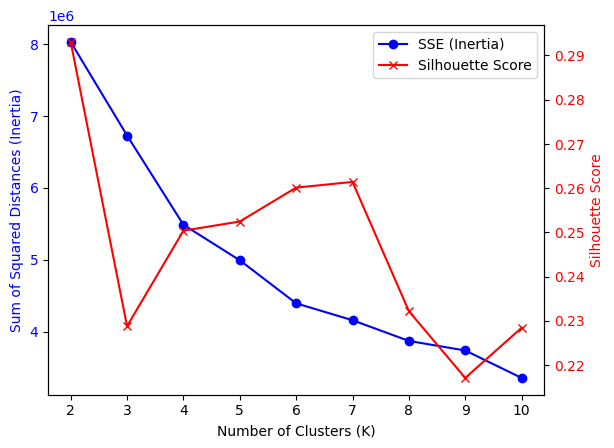

In [19]:
# Standardise the data (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Take 20% of the dataset as a sample size for silhouette score
sample_size = int(len(X_scaled) * 0.02)

# Determine the optimal number of clusters (K) using the Elbow Method
sse = []  # Sum of squared distances to closest cluster center
silhouette_scores = []
for k in range(2, 11):  # Trying different values of K from 2 to 10
    print(f"K = {k} / 10")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled,
                                              kmeans.labels_,
                                              sample_size=sample_size))



fig, ax1 = plt.subplots()

# Plot the first list
ax1.plot(range(2, 11), sse, color='blue', label='SSE (Inertia)', marker='o')
plt.xlabel('Number of Clusters (K)')
ax1.set_ylabel('Sum of Squared Distances (Inertia)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for the second list
ax2 = ax1.twinx()
ax2.plot(range(2, 11), silhouette_scores, color='red', label='Silhouette Score', marker='x')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

In [20]:
max(silhouette_scores)

0.2930637268424155

In [21]:
optimal_k = 7

kmeans = KMeans(optimal_k)
kmeans.fit(X_scaled)

data['cluster'] = kmeans.labels_

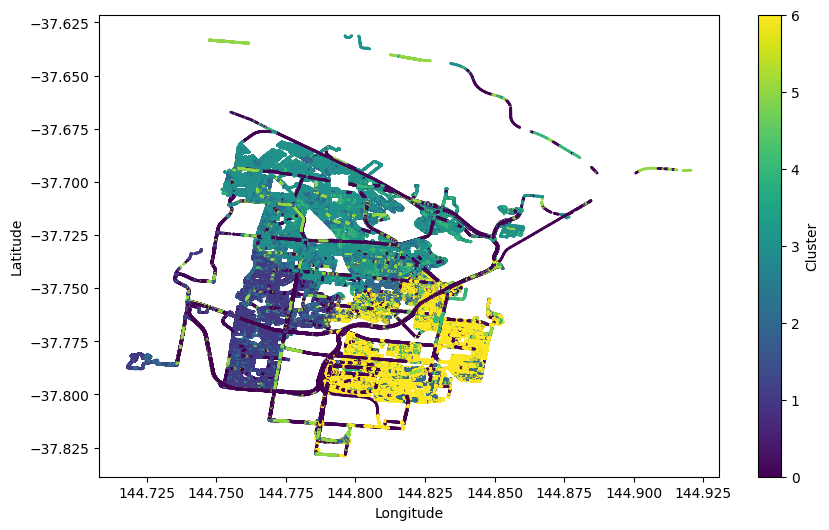

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['cluster'], s=1)
# plt.scatter(centers['longitude'], centers['latitude'], c='red', marker='X', s=20, label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title(f'{k_to_plot} clusters of 5G Network Performance')
plt.colorbar(label='Cluster')
plt.show()

In [23]:
import pickle

# k = 6 has been experimentally determined to be the best
with open("clustering_model_kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("clustering_scaler_kmeans.pkl", "wb") as f:
    pickle.dump(scaler, f)

             speed  total_throughput  average_latency
cluster                                              
0        70.923356         30.964287        87.368720
1         8.163014         25.953773       144.698942
2         7.402444          6.739919       958.138076
3         7.067859         24.839344       115.876282
4         8.527081         64.747543        94.868894
5        68.250010          4.331673       948.669404
6         6.836935         24.546313       114.518944


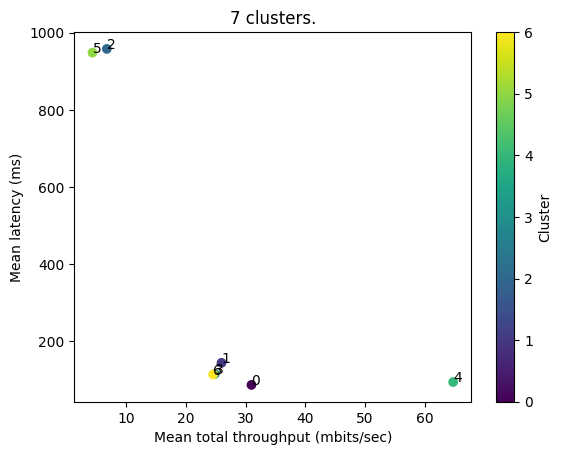

In [28]:
clusters = data[['speed', 'total_throughput', 'average_latency', 'cluster']].groupby('cluster').mean()
print(clusters)

for cluster, row in clusters.iterrows():
    plt.annotate(cluster, row[1:])

plt.title(f"{optimal_k} clusters.")
plt.scatter(clusters['total_throughput'], clusters['average_latency'], c=clusters.index)
plt.colorbar(label='Cluster')
plt.xlabel('Mean total throughput (mbits/sec)')
plt.ylabel('Mean latency (ms)')
plt.show()

       speed  total_throughput  average_latency  class  quality
0  70.923356         30.964287        87.368720      0        1
1   8.163014         25.953773       144.698942      0        1
2   7.402444          6.739919       958.138076      1        0
3   7.067859         24.839344       115.876282      0        1
4   8.527081         64.747543        94.868894      2        2
5  68.250010          4.331673       948.669404      1        0
6   6.836935         24.546313       114.518944      0        1


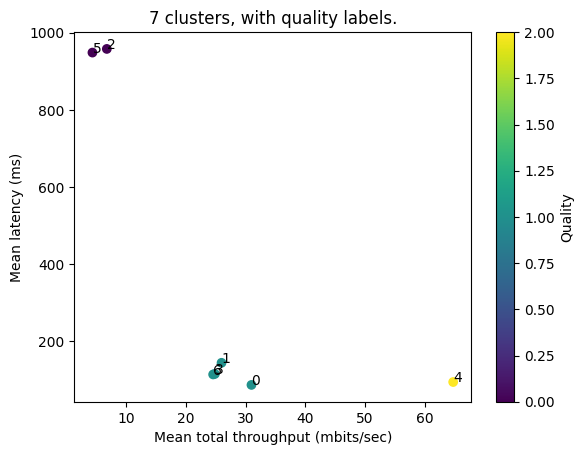

In [37]:
if 'quality' in data.columns:
    data.drop(columns='quality', inplace=True)
    
# Data labelling

N_CLASSES = 3

cluster_to_class_scaler = StandardScaler()
X_c2c_scaled = cluster_to_class_scaler.fit_transform(clusters[['total_throughput', 'average_latency']], clusters.index)

c2c_kmeans = KMeans(N_CLASSES)
c2c_kmeans.fit(X_c2c_scaled)
clusters['class'] = c2c_kmeans.labels_

for cluster, row in clusters.iterrows():
    plt.annotate(cluster, row.iloc[[1, 2]])

HIGH_LATENCY_LOW_THROUGHPUT = 0
LOW_LATENCY_LOW_THROUGHPUT = 1
LOW_LATENCY_HIGH_THROUGHPUT = 2

classes = clusters.groupby('class').mean()
classes['tp_latency'] = classes['total_throughput'] / classes['average_latency']
classes.sort_values('tp_latency', inplace=True)
classes['quality'] = range(len(classes))

cluster_quality = clusters.merge(classes[['quality']], left_on='class', right_on='class')#[['quality']]
print(cluster_quality)
    
data['quality'] = data.merge(cluster_quality, left_on='cluster', right_index=True)['quality']


plt.title(f"{optimal_k} clusters, with quality labels.")
plt.scatter(cluster_quality['total_throughput'], cluster_quality['average_latency'], c=cluster_quality['quality'])
plt.colorbar(label='Quality')
plt.xlabel('Mean total throughput (mbits/sec)')
plt.ylabel('Mean latency (ms)')
plt.show()


# clusters
# clusters.merge(pd.DataFrame(classes['quality'].iloc[clusters['class']]).reset_index(), left_index=True, right_index=True)

# clusters
# clusters['quality'].iloc[
# clusters

# data['class'] = data['cluster'].map(lambda x: clusters['class'].iloc[x])

In [ ]:
import pickle

# k = 6 has been experimentally determined to be the best
with open("c2c_kmeans.pkl", "wb") as f:
    pickle.dump(c2c_kmeans, f)

with open("c2c_scaler.pkl", "wb") as f:
    pickle.dump(c2c_kmeans, f)

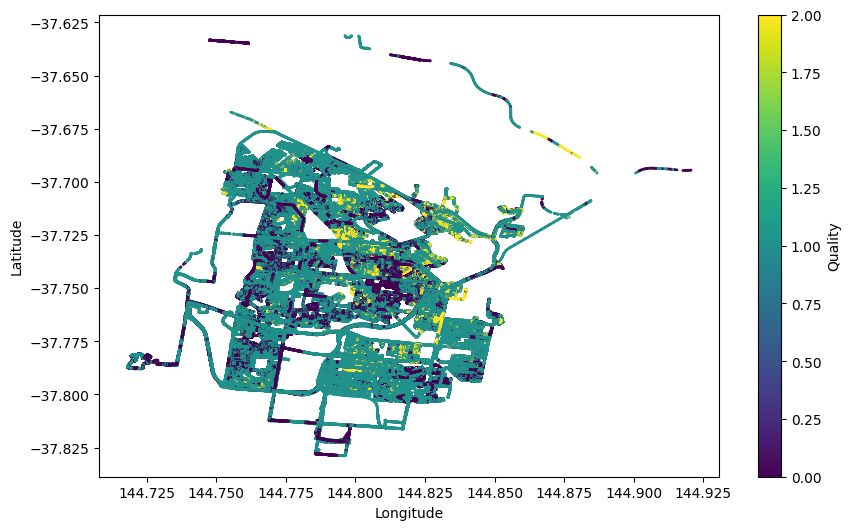

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['quality'], s=1)
# plt.scatter(centers['longitude'], centers['latitude'], c='red', marker='X', s=20, label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title(f'{k_to_plot} clusters of 5G Network Performance')
plt.colorbar(label='Quality')
plt.show()